In [1]:
# coding: utf-8
import gensim, logging
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors as mcolors
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
""モデルをロードする．
データはGoogleが公開している，Google Newsから取得した1兆語について訓練したもの．300万語を300次元で表現している．
原論文が1000次元使っていることを除けば．原論文のものと同じはず．""
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

2018-01-26 16:16:19,037 : INFO : loading projection weights from GoogleNews-vectors-negative300.bin.gz
2018-01-26 16:19:58,144 : INFO : loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


In [3]:
#アナロジー課題をやってみる．v_king + v_woman - v_man = v_queen
model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)

2018-01-26 16:20:33,912 : INFO : precomputing L2-norms of word weight vectors


[('queen', 0.7118192911148071)]

In [12]:
#今回は以下の単語対をデータとして使用する
print(pd.read_csv('word_data_gender.csv', header=None))
print(pd.read_csv('word_data_capital.csv', header=None))

              0            1
0         actor      actress
1        author    authoress
2    bridegroom        bride
3      bachelor     spinster
4           boy         girl
5       brother       sister
6     conductor  conductress
7         count     countess
8          czar      czarina
9           dad          mum
10        daddy        mummy
11         duke      duchess
12      emperor      empress
13       father       mother
14          god      goddess
15  grandfather  grandmother
16           he          she
17         heir      heiress
18         hero      heroine
19         host      hostess
20      husband         wife
21         king        queen
22          man        woman
23       master     mistress
24       mister         miss
25     murderer    murderess
26       nephew        niece
27         poet      poetess
28    policeman  policewoman
29       prince     princess
30          sir        madam
31          son     daughter
32        uncle         aunt
33       waite

In [13]:
#使用する単語ベクトルを取得し，そのリストを作る
def create_word_vector_list(word_data):
    #語を受け取ってモデルから使用する単語ベクトルを取得し，そのリストを作る
    word_vector_list = []
    words = []
    with open(word_data) as f:
        for pair in f:
            word1 = pair.split(',')[0].strip('\n')
            word2 = pair.split(',')[1].strip('\n')
            words.append(word1.capitalize() + ' ' + word2.capitalize())
            X = np.array([model.wv[word1], model.wv[word2]]).T
            word_vector_list.append(X)
    return word_vector_list, words

word_vector_list_capital, words_capital = create_word_vector_list('word_data_capital.csv')
word_vector_list_gender, words_gender = create_word_vector_list('word_data_gender.csv')

In [34]:
#リストの各要素が　(A : B) のそれぞれの単語ベクトルの行列に対応する
print(words_gender[0])
print(word_vector_list_gender[0].shape)

Actor Actress
(300, 2)


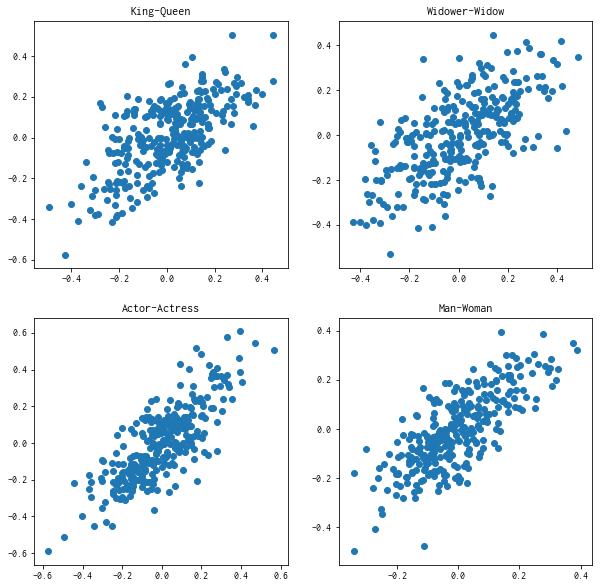

In [21]:
#単語ベクトルをいくつか可視化してみる
#kingとqueen, manとwomanといった対義語同士は強い正の相関を示すことが分かる
widower_widow_vector = word_vector_list_gender[words_gender.index('Widower Widow')]
king_queen_vector = word_vector_list_gender[words_gender.index('King Queen')]
actor_actress_vector = word_vector_list_gender[words_gender.index('Actor Actress')]
man_woman_vector = word_vector_list_gender[words_gender.index('Man Woman')]

plt.figure(figsize=(10,10))

plt.subplot(221)
plt.scatter(king_queen_vector[:, 0], king_queen_vector[:, 1])
plt.title('King-Queen')

plt.subplot(222)
plt.scatter(widower_widow_vector[:, 0], widower_widow_vector[:, 1])
plt.title('Widower-Widow')

plt.subplot(223)
plt.scatter(actor_actress_vector[:, 0], actor_actress_vector[:, 1])
plt.title('Actor-Actress')

plt.subplot(224)
plt.scatter(man_woman_vector[:, 0], man_woman_vector[:, 1])
plt.title('Man-Woman')

plt.show()

In [23]:
#相関係数
print(np.corrcoef(king_queen_vector, rowvar=False))
print(np.corrcoef(widower_widow_vector, rowvar=False))
print(np.corrcoef(actor_actress_vector, rowvar=False))
print(np.corrcoef(man_woman_vector, rowvar=False))

[[1.         0.65076996]
 [0.65076996 1.        ]]
[[1.         0.64930454]
 [0.64930454 1.        ]]
[[1.         0.79310174]
 [0.79310174 1.        ]]
[[1.         0.76599741]
 [0.76599741 1.        ]]


In [26]:
#ndarrayをソートするための関数．固有ベクトルのソートに必要．ここから拝借した (https://stackoverflow.com/questions/33140674/argsort-for-a-multidimensional-ndarray).
def apply_argsort(a, axis=-1):
    i = list(np.ogrid[[slice(x) for x in a.shape]])
    i[axis] = a.argsort(axis)
    return a[i]

#PCAの実装．第二主成分までを取ってくる
def pca(data):
    data -= data.mean(axis=0)
    data_cov = np.cov(data)

    eigenw, eigenv = LA.eigh(data_cov)
    eigenv = apply_argsort(eigenv, axis=0)[::-1]
    FeatureVector = eigenv[:, :2]
    FinalData = FeatureVector.T @ data
    return FinalData

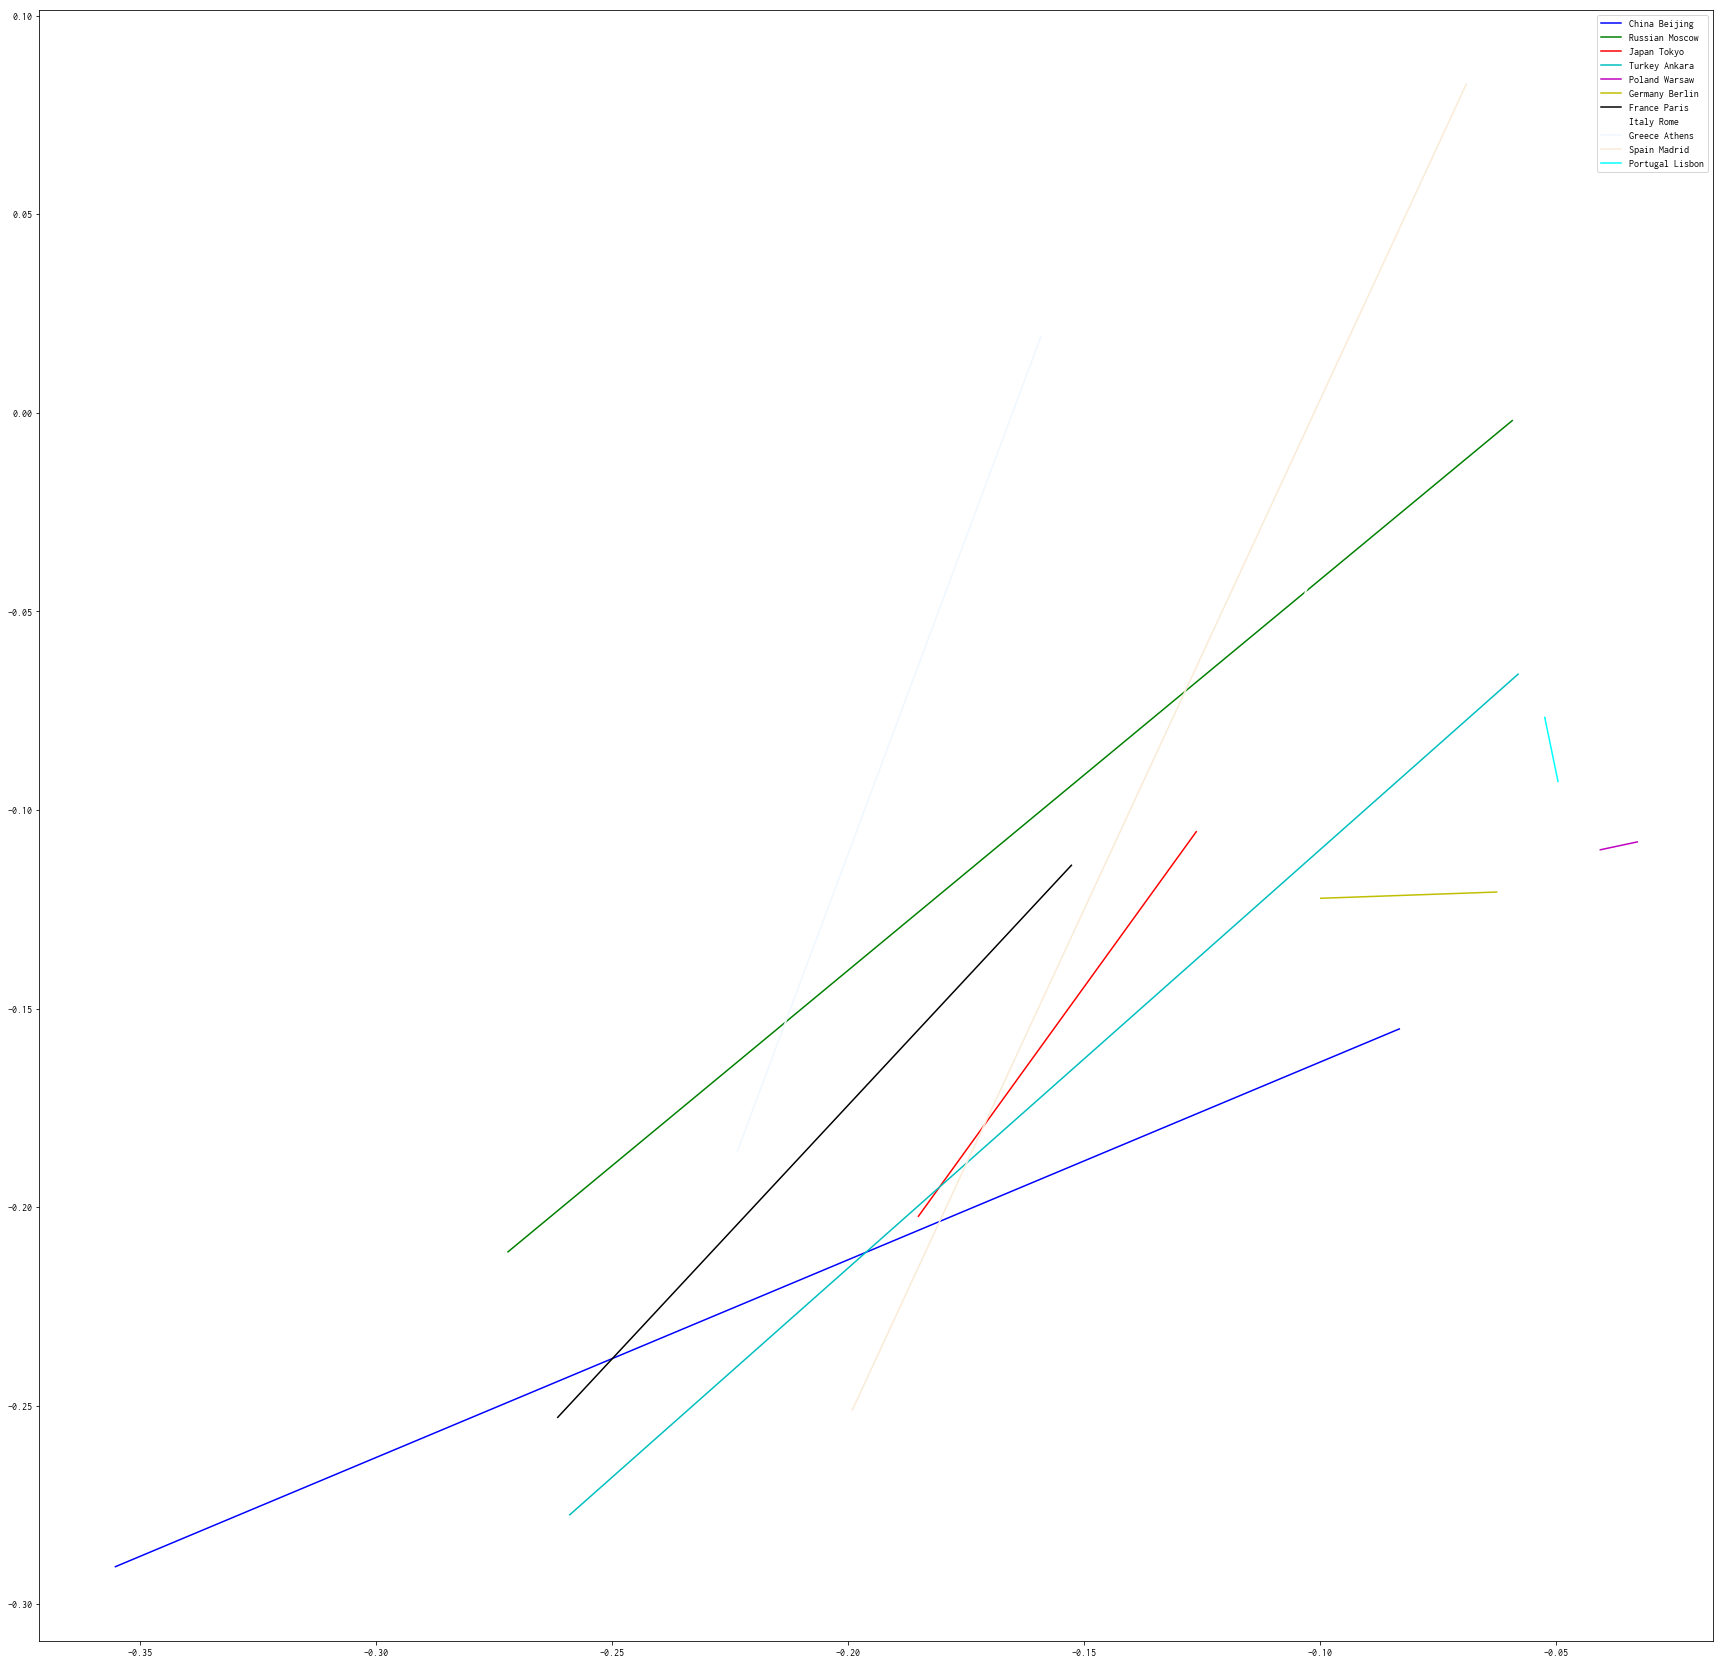

In [30]:
#それぞれの単語ベクトルに主成分分析を適用したものをプロットする
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
#まずは原論文のCountry-Capitalを再現できるか試す．大体平行になっているのが，いくつかずれてるのが...何か間違ってる？原論文通りなら，もう少しきれいに平行になるはず
fig = plt.figure(figsize=(30,30))
for word_vector, word, color in zip(word_vector_list_capital, words_capital, colors):
    FinalData = pca(word_vector)
    plt.plot(FinalData[0], FinalData[1], color=color, label=word)
    plt.legend()
plt.show()

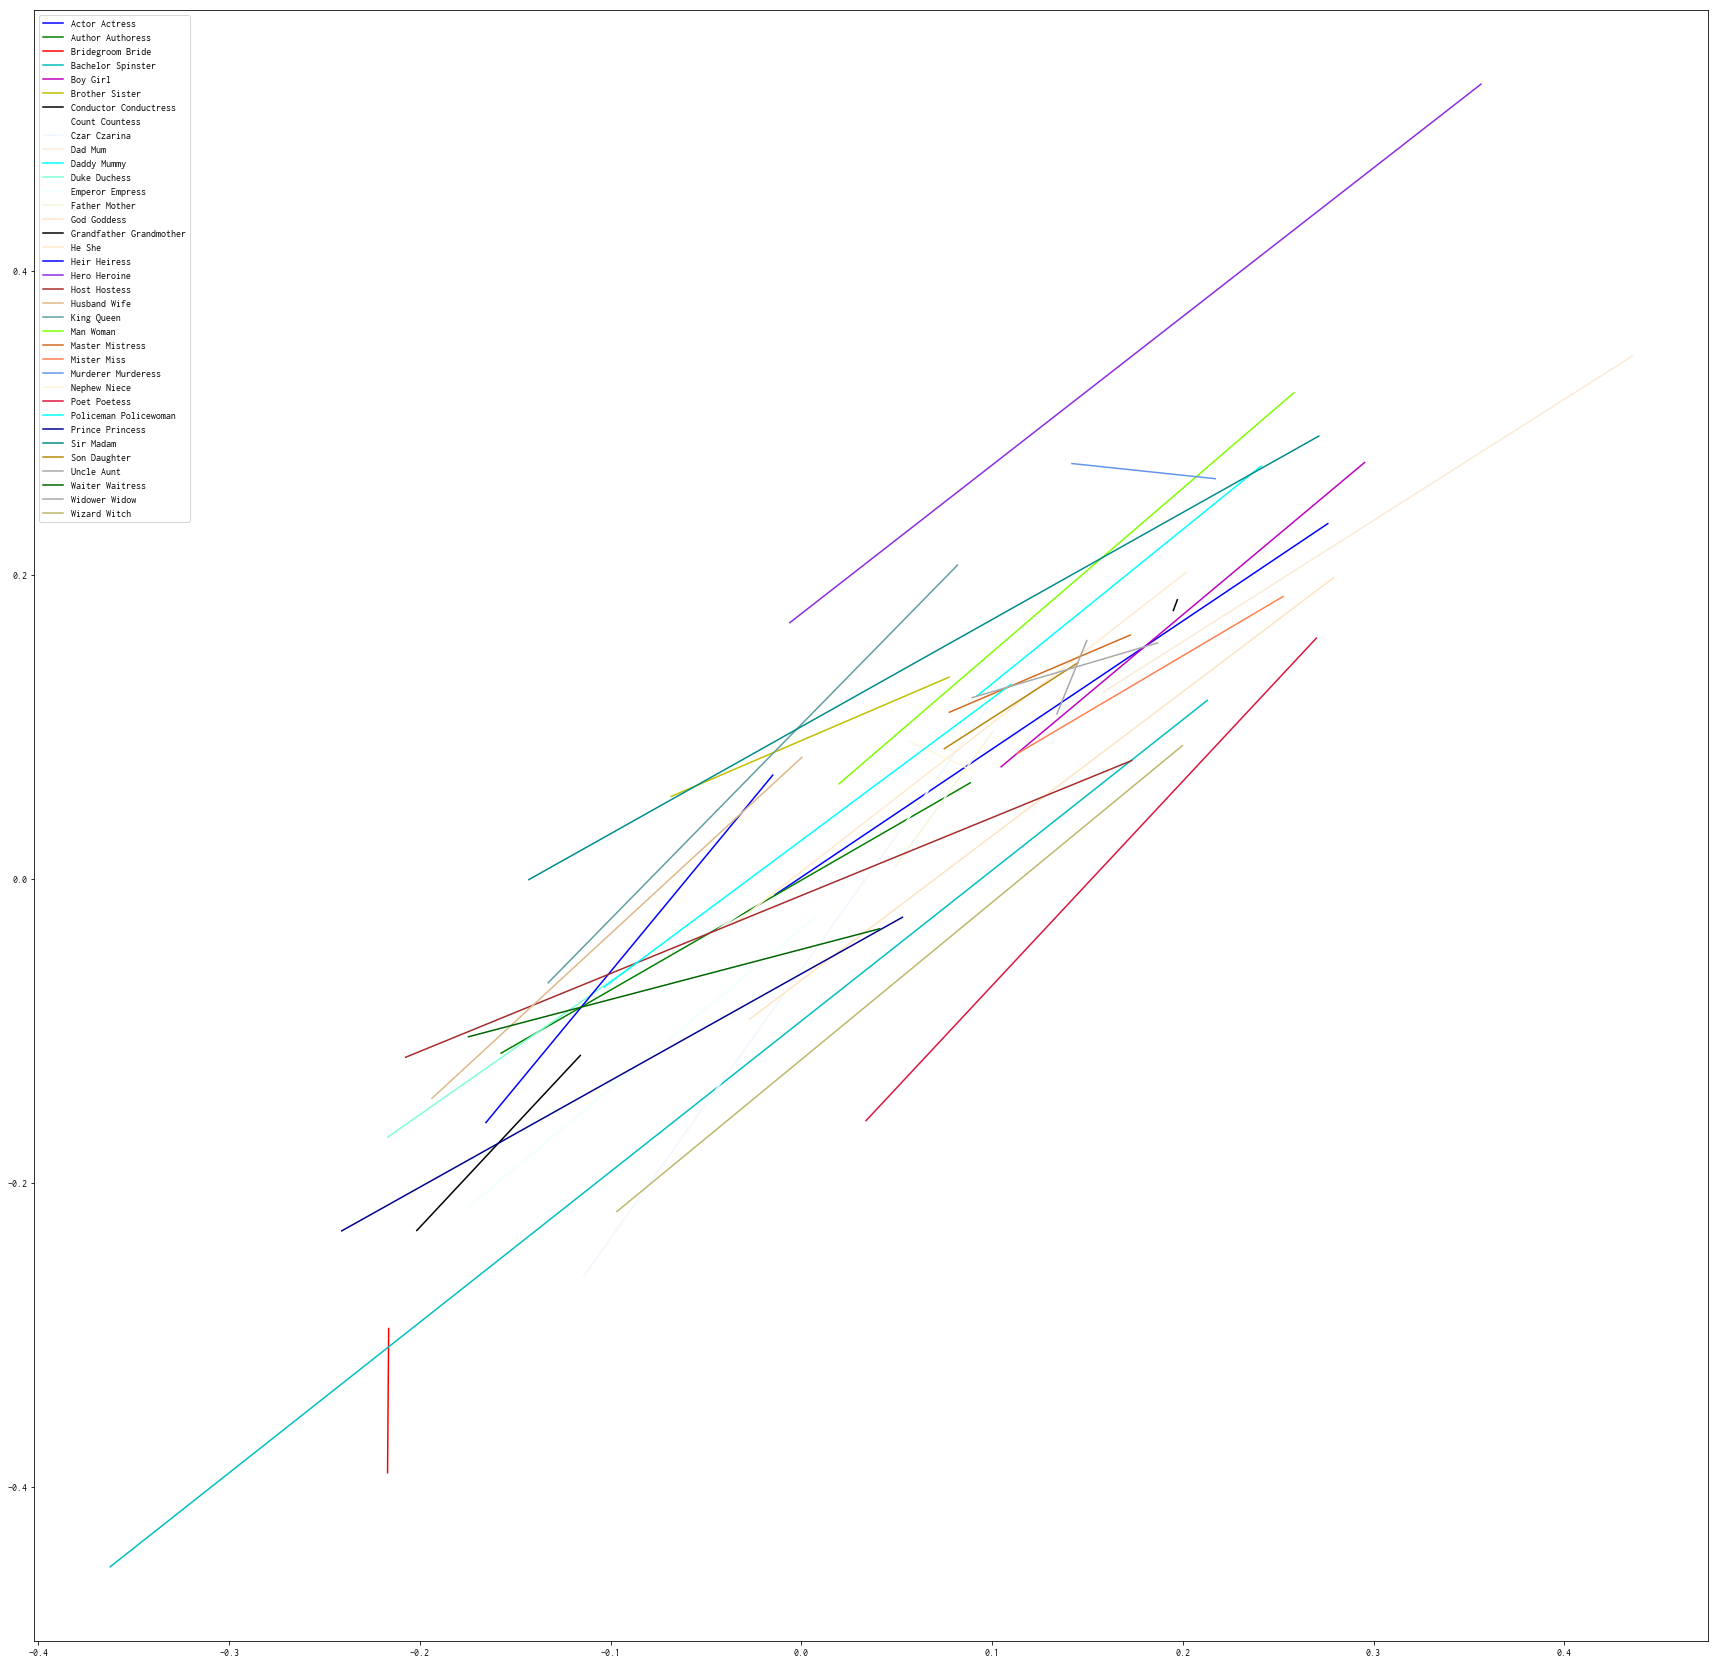

In [29]:
#Man-Woman．両方のプロット共に言えることだが，全体的にきれいに右肩上がりなってるのどうなんだろう？
fig = plt.figure(figsize=(30,30))
for word_vector, word, color in zip(word_vector_list_gender, words_gender, colors):
    FinalData = pca(word_vector)
    #print(FinalData)
    plt.plot(FinalData[0][:2], FinalData[1][:2], color=color, label=word)
    plt.legend()
plt.show()
